In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb

The file _gams_py_gdb9.gdx is still active and was not deleted.


*Load specific modules used here:*

In [2]:
os.chdir(d['py'])
import mCGE

# Emission policies

*Load model:*

In [3]:
name = 'NCP_H2M'
M = mCGE.NCP_CGE.load(os.path.join(d['data'], name))
ws = M.ws
db0 = M.db.copy() # initial solution
sols = {'Baseline': db0} # collect solutions here
tPlot = M.db('t')[0:60] # what time horizon are we looking at in plots

## 1. Implement SYT regulation 

### SYT_EXO

First, assume that CO2 taxes are kept at current levels in years prior to target years. Then, update regulation to 'SYT_EXO' (single year target with exogenous paths prior to target year) and solve:

In [4]:
M.db['tauCO2agg0'] = M.db('tauCO2agg').copy()
M.stdEmissionTargets('MT') # add module with targets
M.db.mergeInternal() # write GDX file
sols['SYT_EXO'] = M.jSolve(25, state = 'B')

A brief look at how emissions and taxes evolve in baseline and regulated instances:

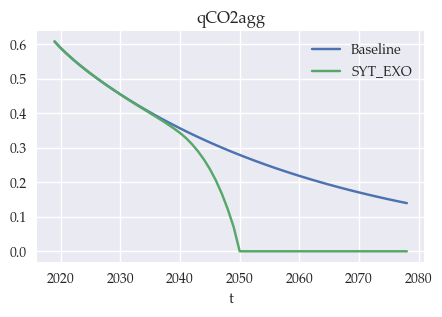

In [5]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_EXO')}), tPlot).plot(figsize=(5,3), title = var);

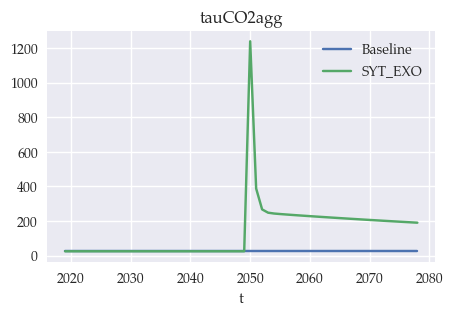

In [6]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_EXO')}), tPlot).plot(figsize=(5,3), title = var);

### SYT_HR

Assume instead that taxes follows a hotelling-like rule in years prior to the target:

In [7]:
M.updateRegulation('SYT_HR')
sols['SYT_HR'] = M.jSolve(25, state = 'B')

A brief look at how emissions and taxes evolve in baseline and regulated instances:

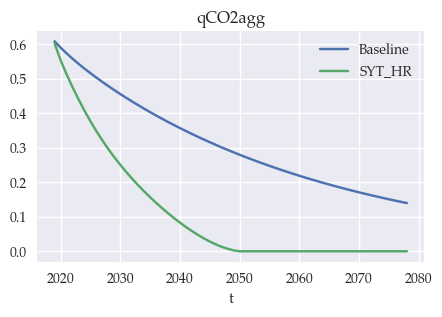

In [8]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_HR')}), tPlot).plot(figsize=(5,3), title = var);

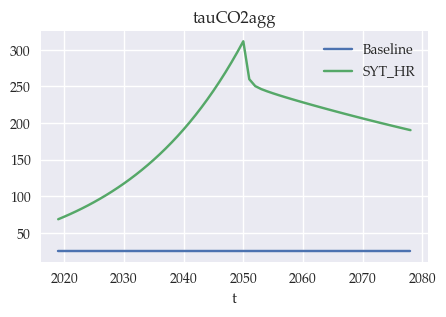

In [9]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_HR')}), tPlot).plot(figsize=(5,3), title = var);

### SYT_OPT

Now, instead, use numerical optimization to determine the path of CO2 taxes. Start from SYT_EXO solution:

In [10]:
[M.db.__setitem__(k, sols['SYT_EXO'][k]) for k in M.db.getTypes(['var']) if k in sols['SYT_EXO'].symbols]; # use solution database
M.db.mergeInternal() # update database
# M.updateRegulation('SYT_OPT')
# sols['SYT_OPT'] = M.solve()

One issue with this approach is that we cannot use the 'jSolve' with NLP. Instead, what we can do, is to gradually open up for the number of instruments that can be used:
* Start by adding the 'SYT_EXO' module again and add a checkpoint.
* Then, adjust regulation type again to SYT_OPT. Write a text that, from this checkpoint, defines the model.
* Fix CO2 taxes again for all non-binding periods (similar to EXO solution).
* We can then try to adjust all tax rates simultaneously, or iteratively open up for one additional one.

In [11]:
M.updateRegulation('SYT_EXO') # update to SYT_EXO regulation again
cp = ws.add_checkpoint()
M.job = M.ws.add_job_from_string(M.write())
M.job.run(databases = M.db.database, checkpoint = cp) # store checkoint
M.updateRegulation('SYT_OPT')

In [12]:
text = f"""
{M.compiler(M.defineModel(), has_read_file=True)}
tauCO2agg.lo[t]$(t_SYT_NB[t]) = tauCO2agg.l[t];
tauCO2agg.up[t]$(t_SYT_NB[t]) = tauCO2agg.l[t];

# Everything in one go:
tauCO2agg.lo[t]$(t_SYT_NB[t]) = 1; # lower bound >0 for numerical stability.
tauCO2agg.up[t]$(t_SYT_NB[t]) = inf;
{M.solveStatement()}


## Loop forward:

# Scalar scalarTemp;
# for (scalarTemp = 2020 to 2049,
#     tauCO2agg.lo(t)$(t.val = scalarTemp) = 1; # lower bound >0 for numerical stability.
#     tauCO2agg.up(t)$(t.val = scalarTemp) = inf;
#     {M.solveStatement()}
# );


## Loop backwards:
# Parameter year;
# Scalar scalarTemp;

# year = 2049;
# Scalar endYear /2048/;

# While(year >= endYear,
#     scalarTemp = year;
#     tauCO2agg.lo(t)$(t.val = scalarTemp) = 1; # lower bound >0 for numerical stability.
#     tauCO2agg.up(t)$(t.val = scalarTemp) = inf;
#     {M.solveStatement()}
#     year = year - 1;
# );

"""

In [13]:
M.job = M.ws.add_job_from_string(text, checkpoint = cp)
M.job.run()
sols['SYT_OPT'] = GpyDB(M.job.out_db)

Illustrate emissions and taxes:

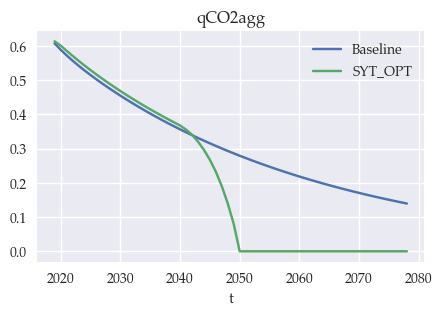

In [14]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_OPT')}), tPlot).plot(figsize=(5,3), title = var);

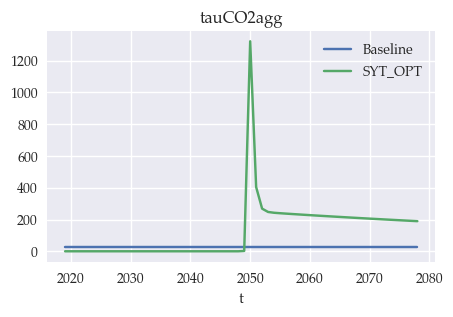

In [15]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_OPT')}), tPlot).plot(figsize=(5,3), title = var);

## 2. LRP 

Update regulation, turn off welfare optimizing module, go back to SYT solution with hotelling rule and solve:

In [16]:
M.updateRegulation('LRP')
M.opt = False 
[M.db.__setitem__(k, sols['SYT_HR'][k]) for k in M.db.getTypes(['var']) if k in sols['SYT_HR'].symbols]; # use solution database
M.db.mergeInternal() # update database
sols['LRP'] = M.jSolve(5, state = 'B')

Illustrate emissions and taxes: Compare with Hotelling rule solution

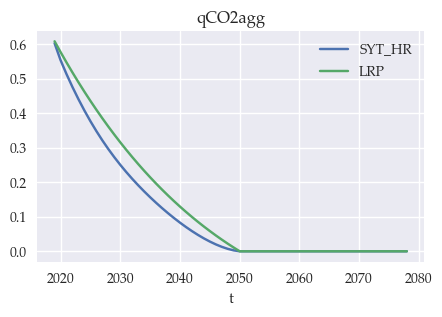

In [17]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('SYT_HR','LRP')}), tPlot).plot(figsize=(5,3), title = var);

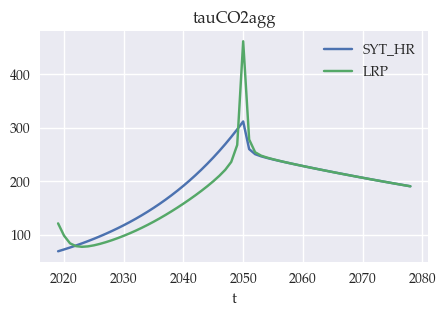

In [18]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('SYT_HR','LRP')}), tPlot).plot(figsize=(5,3), title = var);

## 3. Emission budget

Update to emission budget rule and solve again:

In [19]:
M.updateRegulation('EB_HR')
M.opt = False
sols['EB_HR'] = M.solve()

Plot again:

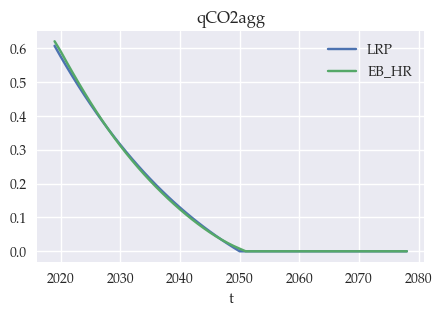

In [20]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('LRP','EB_HR')}), tPlot).plot(figsize=(5,3), title = var);

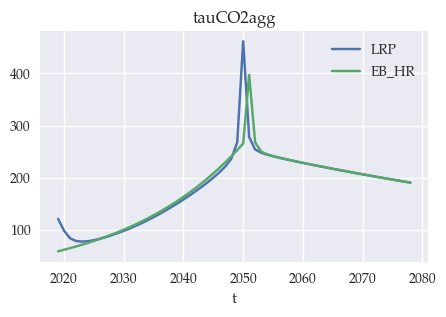

In [21]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('LRP','EB_HR')}), tPlot).plot(figsize=(5,3), title = var);

### EB_OPT

Now, instead, use numerical optimization to determine the path of CO2 taxes. Start from EB_HR solution:

In [26]:
[M.db.__setitem__(k, sols['EB_HR'][k]) for k in M.db.getTypes(['var']) if k in sols['EB_HR'].symbols]; # use solution database
M.db.mergeInternal() # update database
# M.updateRegulation('EB_OPT')
# sols['EB_OPT'] = M.solve()

In [27]:
M.updateRegulation('EB_HR') # update to EB_HR regulation again
cp = ws.add_checkpoint()
M.job = M.ws.add_job_from_string(M.write())
M.job.run(databases = M.db.database, checkpoint = cp) # store checkoint
M.updateRegulation('EB_OPT')

In [30]:
text = f"""
{M.compiler(M.defineModel(), has_read_file=True)}
tauCO2agg.lo[t]$(t_EB_NB[t]) = tauCO2agg.l[t];
tauCO2agg.up[t]$(t_EB_NB[t]) = tauCO2agg.l[t];

# Everything in one go:
tauCO2agg.lo[t]$(t_EB_NB[t]) = 1; # lower bound >0 for numerical stability.
tauCO2agg.up[t]$(t_EB_NB[t]) = inf;
{M.solveStatement()}


## Loop forward:

# Scalar scalarTemp;
# for (scalarTemp = 2020 to 2049,
#     tauCO2agg.lo(t)$(t.val = scalarTemp) = 1; # lower bound >0 for numerical stability.
#     tauCO2agg.up(t)$(t.val = scalarTemp) = inf;
#     {M.solveStatement()}
# );


## Loop backwards:
# Parameter year;
# Scalar scalarTemp;

# year = 2049;
# Scalar endYear /2048/;

# While(year >= endYear,
#     scalarTemp = year;
#     tauCO2agg.lo(t)$(t.val = scalarTemp) = 1; # lower bound >0 for numerical stability.
#     tauCO2agg.up(t)$(t.val = scalarTemp) = inf;
#     {M.solveStatement()}
#     year = year - 1;
# );

"""

In [32]:
M.job = M.ws.add_job_from_string(text, checkpoint = cp)
M.job.run()
sols['EB_OPT'] = GpyDB(M.job.out_db)

Plot again:

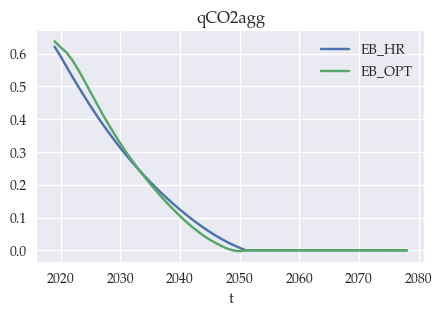

In [33]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('EB_HR','EB_OPT')}), tPlot).plot(figsize=(5,3), title = var);

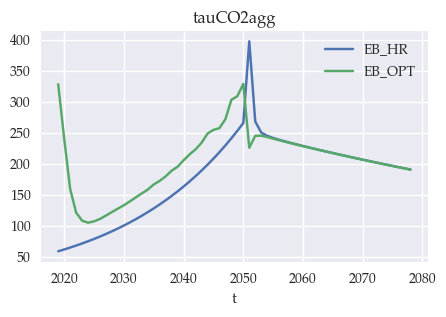

In [34]:
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('EB_HR','EB_OPT')}), tPlot).plot(figsize=(5,3), title = var);

### Plots

Compare qCO2agg for Baseline, SYT_EXO, SYT_HR, SYT_OPT og LRP:

In [52]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=long_colors)

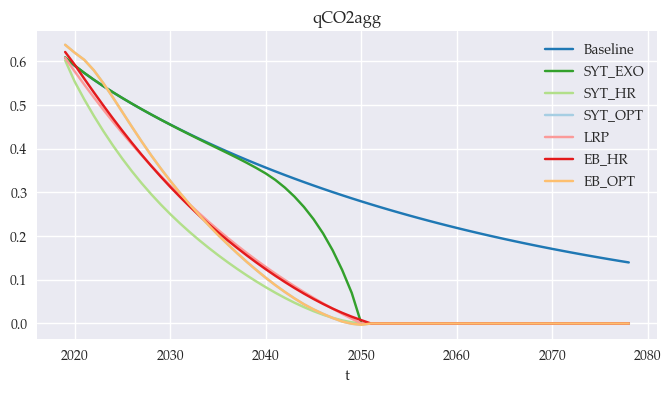

In [53]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('Baseline','SYT_EXO','SYT_HR','SYT_OPT','LRP','EB_HR','EB_OPT')}), tPlot).plot(figsize=(8,4), title = var);

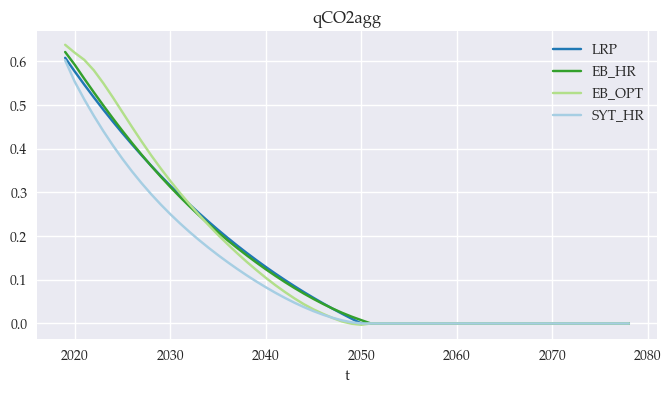

In [54]:
var = 'qCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var) for k in ('LRP','EB_HR','EB_OPT','SYT_HR')}), tPlot).plot(figsize=(8,4), title = var);

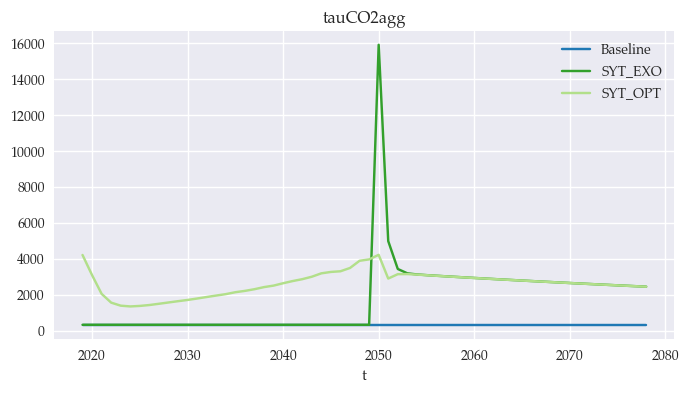

In [55]:
mult = db0._scale/(db0('M1990') * 1e6)
var = 'tauCO2agg'
adj.rc_pd(pd.DataFrame({k: sols[k](var)*mult for k in ('Baseline','SYT_EXO','SYT_OPT')}), tPlot).plot(figsize=(8,4), title = var);

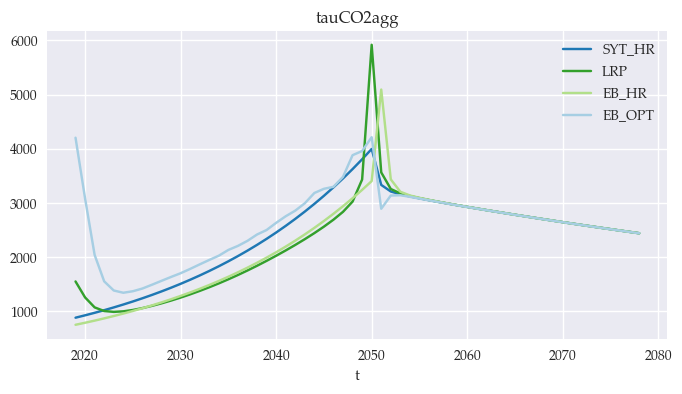

In [56]:
adj.rc_pd(pd.DataFrame({k: sols[k](var)*mult for k in ('SYT_HR','LRP','EB_HR','EB_OPT')}), tPlot).plot(figsize=(8,4), title = var);

Compare welfare:

<Axes: title={'center': 'vU'}, xlabel='s'>

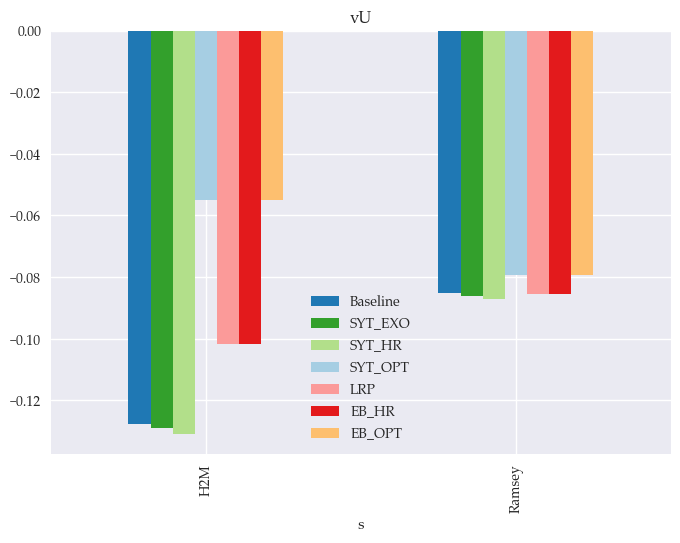

In [57]:
var = 'vU'
pd.DataFrame({k: sols[k](var).xs(2019) for k in ('Baseline','SYT_EXO','SYT_HR','SYT_OPT','LRP','EB_HR','EB_OPT')}).plot.bar(title = var)

In [59]:
db = db0

Test:

In [102]:
testRun = f"""
E_inc[t,s]$(s_HH[s] and txE[t])..     inc[t,s]  =E= vA[t+1,s]*(1+g_LR)-Rrate[t]*vA[t,s]+sum([n,nn]$(L2C[s,nn,n]), pD[t,s,n])*qC[t,s];
E_Hinc[t,s]$(s_HH[s] and txE[t])..    Hinc[t,s] =E= Rrate[t]*(Hinc[t-1,s]-inc[t-1,s])/(1+g_LR);
E_Hinc_tE[t,s]$(s_HH[s] and tE[t])..   Hinc[t,s] =E= inc[t-1,s]/(1-(1+g_LR)/R_LR); # 
E_pU_tE[t,s]$(s_HH[s] and tE[t])..       pU[t,s]   =E= sum([n,nn]$(L2C[s,nn,n]) pD[t,s,n])*(1/(1-discF[s]**(1/crra[s]) / (R_LR**(1-1/crra[s]))))**(1/(1-1/crra[s]));
E_pU[t,s]$(s_HH[s] and txE[t])..    pU[t,s] =E= sum([n,nn]$(L2C[s,nn,n]) pD[t,s,n])*(1/(1-discF[s]**(1/crra[s])
"""